In [1]:
!nvidia-smi

Tue Apr 13 23:22:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 45%   40C    P0    N/A /  75W |    617MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Импортирование библиотек

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import random as rn
import sys
import os
import PIL
from PIL import ImageOps, ImageFilter
from tqdm import tqdm
from datetime import datetime

print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Reproducibility

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# Основные настройки

In [5]:
path_train = 'B:/SKILL_FACTORY/chest_xray/train/'
path_train_norm = 'B:/SKILL_FACTORY/chest_xray/train/NORMAL/'
path_train_pn = 'B:/SKILL_FACTORY/chest_xray/train/PNEUMONIA/'

path_test = 'B:/SKILL_FACTORY/chest_xray/test/'
path_test_norm = 'B:/SKILL_FACTORY/chest_xray/test/NORMAL/'
path_test_pn = 'B:/SKILL_FACTORY/chest_xray/test/PNEUMONIA/'

path_val = 'B:/SKILL_FACTORY/chest_xray/val/'
path_val_norm = 'B:/SKILL_FACTORY/chest_xray/val/NORMAL/'
path_val_pn = 'B:/SKILL_FACTORY/chest_xray/val/PNEUMONIA/'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 2  # количество классов в нашей задаче
IMG_SIZE             = 128 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 1   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [6]:
# Parameters Based on Paper
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005
epochs = 2
no_of_secondary_capsules = CLASS_NUM

optimizer = tf.keras.optimizers.Adam()

In [7]:
params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": CLASS_NUM,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
}

In [8]:
checkpoint_path = './logs/model/capsule'

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = './logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = './logs/scalars/%s' % stamp
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

# EDA + Подготовка данных

In [9]:
sum_train = len(os.listdir(path_train_norm)) + len(os.listdir(path_train_pn))
sum_test = len(os.listdir(path_test_norm)) + len(os.listdir(path_test_pn))
sum_val = len(os.listdir(path_val_norm)) + len(os.listdir(path_val_pn))

print(f'{round(len(os.listdir(path_train_norm))/sum_train,2)} || {round(len(os.listdir(path_train_pn))/sum_train,2)}  {sum_train}')
print(f'{round(len(os.listdir(path_test_norm))/sum_test,2)} || {round(len(os.listdir(path_test_pn))/sum_test,2)}  {sum_test}')
print(f' {round(len(os.listdir(path_val_norm))/sum_val,2)} || {round(len(os.listdir(path_val_pn))/sum_val,2)}   {sum_val}')

0.26 || 0.74  5216
0.38 || 0.62  624
 0.5 || 0.5   16


In [10]:
def print_all_classes():
    
    
    '''Вывод 1й картинки каждого класса машин'''

    
    cols = 5
    rows = 2
    fig = plt.figure(figsize=(4 * cols - 1, 4 * rows - 1))

    count = 0
    for i in range(cols):
        for j in range(rows):
            if count <5:
                image = PIL.Image.open(
                    path_train+'NORMAL/'+os.listdir(path_train+'NORMAL/')[count],
                    formats=['JPEG'])
            else:
                image = PIL.Image.open(
                    path_train+'PNEUMONIA/'+os.listdir(path_train+'PNEUMONIA/')[count],
                    formats=['JPEG'])
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(image, cmap='gray')
            if count <5:
                ax.set_title(f'Category: NORMAL')
            else:
                ax.set_title(f'Category: PNEUMONIA')
            count += 1

    plt.show()

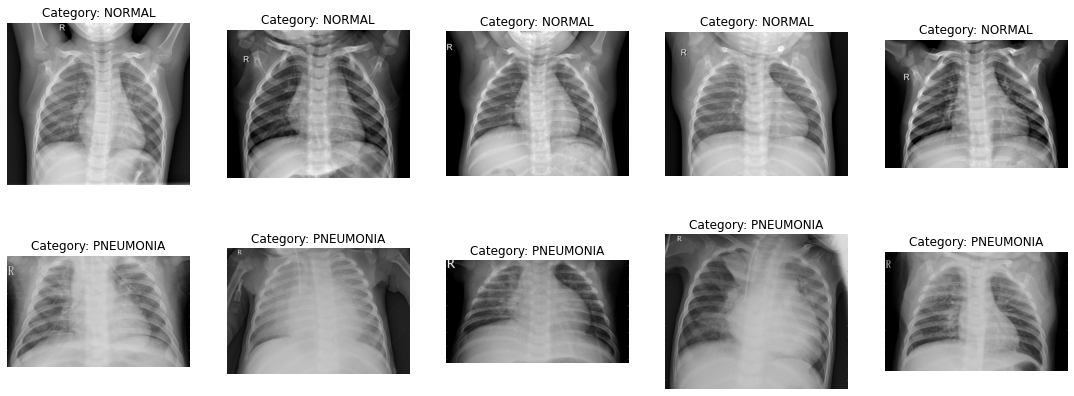

In [11]:
print_all_classes()

In [12]:
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(len(os.listdir(path_train+'NORMAL/'))):
    image = PIL.Image.open(path_train+'NORMAL/'+os.listdir(path_train+'NORMAL/')[i],
                      formats=['JPEG'])
    image = image.resize((IMG_SIZE,IMG_SIZE))
    if len(np.array(image.getdata()).shape) > 1:
        image = image.convert('L')
    image = np.array(image.getdata()).reshape((IMG_SIZE,IMG_SIZE))
    X_train.append(image)
    y_train.append(0)
    
for i in range(len(os.listdir(path_train+'PNEUMONIA/'))):
    image = PIL.Image.open(path_train+'PNEUMONIA/'+os.listdir(path_train+'PNEUMONIA/')[i],
                      formats=['JPEG'])
    image = image.resize((IMG_SIZE,IMG_SIZE))
    if len(np.array(image.getdata()).shape) > 1:
        image = image.convert('L')
    image = np.array(image.getdata()).reshape((IMG_SIZE,IMG_SIZE))
    X_train.append(image)
    y_train.append(1)
    
for i in range(len(os.listdir(path_test+'NORMAL/'))):
    image = PIL.Image.open(path_test+'NORMAL/'+os.listdir(path_test+'NORMAL/')[i],
                      formats=['JPEG'])
    image = image.resize((IMG_SIZE,IMG_SIZE))
    if len(np.array(image.getdata()).shape) > 1:
        image = image.convert('L')
    image = np.array(image.getdata()).reshape((IMG_SIZE,IMG_SIZE))
    X_test.append(image)
    y_test.append(0)
    
for i in range(len(os.listdir(path_test+'PNEUMONIA/'))):
    image = PIL.Image.open(path_test+'PNEUMONIA/'+os.listdir(path_test+'PNEUMONIA/')[i],
                      formats=['JPEG'])
    image = image.resize((IMG_SIZE,IMG_SIZE))
    if len(np.array(image.getdata()).shape) > 1:
        image = image.convert('L')
    image = np.array(image.getdata()).reshape((IMG_SIZE,IMG_SIZE))
    X_test.append(image)
    y_test.append(1)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5216, 128, 128)
(5216,)
(624, 128, 128)
(624,)


In [14]:
X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5216, 128, 128, 1)
(5216,)
(624, 128, 128, 1)
(624,)


In [16]:
testing_dataset_size = X_test.shape[0]
training_dataset_size = X_train.shape[0]

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=BATCH_SIZE)

In [18]:
testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testing = testing.batch(batch_size=BATCH_SIZE)

# Строим модель

In [19]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, no_of_conv_kernels, no_of_primary_capsules, primary_capsule_vector, no_of_secondary_capsules, secondary_capsule_vector, r):
        super(CapsuleNetwork, self).__init__()
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r
        
        
        with tf.name_scope("Variables") as scope:
            
            self.convolution = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution1 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution2 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution3 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution4 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution5 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution6 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution7 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution8 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution9 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution10 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution11 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.convolution12 = tf.keras.layers.Conv2D(self.no_of_conv_kernels, 
                                                      [9,9],
                                                      strides=[1,1], 
                                                      name='ConvolutionLayer', 
                                                      activation='relu')

            self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsule_vector, 
                                                          [9,9], 
                                                          strides=[2,2], 
                                                          name="PrimaryCapsule")
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 
                                                                       2048,
                                                                       self.no_of_secondary_capsules,
                                                                       self.secondary_capsule_vector, 
                                                                       self.primary_capsule_vector]), 
                                                                       dtype=tf.float32, name="PoseEstimation",
                                                                       trainable=True)
            self.dense_1 = tf.keras.layers.Dense(units = 512, 
                                                 activation='relu')
            self.dropout1 = tf.keras.layers.Dropout(rate = 0.25)
            self.dense_2 = tf.keras.layers.Dense(units = 1024, 
                                                 activation='relu')
            self.dropout2 = tf.keras.layers.Dropout(rate = 0.5)
            self.dense_3 = tf.keras.layers.Dense(units = 16384, 
                                                 activation='sigmoid', 
                                                 dtype='float32')
        
    def build(self, input_shape):
        pass
        
    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + epsilon)
    
    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)
        
        x = self.convolution(input_x) # x.shape: (None, 20, 20, 256)
        x = self.convolution1(x) 
        x = self.convolution2(x) 
        x = self.convolution3(x) 
        x = self.convolution4(x) 
        x = self.convolution5(x) 
        x = self.convolution6(x) 
        x = self.convolution7(x) 
        x = self.convolution8(x) 
        x = self.convolution9(x) 
        x = self.convolution10(x) 
        x = self.convolution11(x) 
        x = self.convolution12(x)# 24 24 256

        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256) # 8 8 256
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0], 2048, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
                
        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)
            
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dropout1(reconstructed_image)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dropout2(reconstructed_image)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        
        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.convolution1(x) 
        x = self.convolution2(x) 
        x = self.convolution3(x) 
        x = self.convolution4(x) 
        x = self.convolution5(x) 
        x = self.convolution6(x) 
        x = self.convolution7(x) 
        x = self.convolution8(x) 
        x = self.convolution9(x) 
        x = self.convolution10(x) 
        x = self.convolution11(x) 
        x = self.convolution12(x)# 24 24 256

        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256) # 8 8 256
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 
                          2048, 
                          self.no_of_secondary_capsules, 
                          1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, 
                                              u_hat), 
                                              axis=1, 
                                              keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), 
                                                 tf.expand_dims(v, axis=-1), 
                                                 transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dropout1(reconstructed_image)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dropout2(reconstructed_image)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image

In [20]:
tf.summary.trace_on(graph=True, profiler=True)

Instructions for updating:
use `tf.profiler.experimental.start` instead.


In [21]:
model = CapsuleNetwork(**params)

In [22]:
def safe_norm(v, axis=-1, epsilon=1e-7):
    v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
    return tf.sqrt(v_ + epsilon)

In [23]:
def loss_function(v, reconstructed_image, y, y_image):
    prediction = safe_norm(v)
    prediction = tf.reshape(prediction, [-1, no_of_secondary_capsules])
    
    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))
    
    l = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)
    
    margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis=-1))
    
    y_image_flat = tf.reshape(y_image, [-1, 16384])
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))
    
    loss = tf.add(margin_loss, alpha * reconstruction_loss)
    
    return loss

In [24]:
def train(x,y):
    y_one_hot = tf.one_hot(y, depth=CLASS_NUM)
    with tf.GradientTape() as tape:
        v, reconstructed_image = model([x, y_one_hot])
        loss = loss_function(v, reconstructed_image, y_one_hot, x)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [25]:
_ = train(X_train[:1],y_train[:1])
with writer.as_default():
    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [26]:
tf.summary.trace_off()

In [27]:
model.summary()

Model: "capsule_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvolutionLayer (Conv2D)    multiple                  20992     
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple                  5308672   
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple                  5308672   
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple                  5308672   
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple                  5308672   
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple                  5308672   
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple              

In [28]:
def predict(model, x):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    return np.argmax(pred, axis=1)[:,0]

In [29]:
checkpoint = tf.train.Checkpoint(model=model)

In [30]:
losses = []
accuracy = []
for i in range(1, epochs+1, 1):

    loss = 0
    with tqdm(total=len(dataset)) as pbar:
        
        description = "Epoch " + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)

        for X_batch, y_batch in dataset:

            loss += train(X_batch,y_batch)
            pbar.update(1)

        loss /= len(dataset)
        losses.append(loss.numpy())
        
        training_sum = 0

        print_statement = "Loss :" + str(loss.numpy()) + " Evaluating Accuracy ..."
        pbar.set_postfix_str(print_statement)

        for X_batch, y_batch in dataset:
            training_sum += sum(predict(model, X_batch)==y_batch.numpy())
        accuracy.append(training_sum/training_dataset_size)

        with file_writer.as_default():
            tf.summary.scalar('Loss', data=loss.numpy(), step=i)
            tf.summary.scalar('Accuracy', data=accuracy[-1], step=i)
        
        print_statement = "Loss :" + str(loss.numpy()) + " Accuracy :" + str(accuracy[-1])

        if i % 10 == 0:
            print_statement += ' Checkpoint Saved'
            checkpoint.save(checkpoint_path)
        
        pbar.set_postfix_str(print_statement)

Epoch 2/2: 100%|███████████████| 1304/1304 [1:19:03<00:00,  3.64s/it, Loss :0.40500852 Accuracy :0.3199769938650307]


In [31]:
checkpoint.save(checkpoint_path)

'./logs/model/capsule-1'

In [32]:
test_sum = 0
for X_batch, y_batch in testing:
    test_sum += sum(predict(model, X_batch)==y_batch.numpy())
print(test_sum/testing_dataset_size)

0.4150641025641026


In [ ]:
checkpoint_model_path = './logs/model/capsule-1'

In [ ]:
checkpoint.restore(checkpoint_model_path)

In [ ]:
y_test[:90]

In [ ]:
X_test.shape

In [ ]:
index_ = 1
index = 1

In [ ]:
print(predict(model, tf.expand_dims(X_test[index_], axis=0)), y_test[index_])

In [ ]:
features = model.predict_capsule_output(tf.expand_dims(X_test[index_], axis=0))

In [ ]:
features.shape

In [ ]:
temp_features = features.numpy()
temp_ = temp_features.copy()
temp_features[:,:,:,:] = 0
temp_features[:,:,index,:] = temp_[:,:,index,:]
recon = model.regenerate_image(temp_features)
recon = tf.reshape(recon, (28,28))
plt.imshow(recon, cmap='gray')

In [ ]:
temp_features = features.numpy()
temp_ = temp_features.copy()
temp_features[:,:,:,:] = 0
temp_features[:,:,index,:] = temp_[:,:,index,:]

recon = model.regenerate_image(temp_features)
recon = tf.reshape(recon, (28,28))

plt.subplot(1,2,1)
plt.imshow(recon, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[index_,:,:,0], cmap='gray')

In [ ]:
col = np.zeros((28,308))
for i in range(16): 
    feature_ = temp_features.copy()
    feature_[:,:,index, i] += -0.25
    row = np.zeros((28,28))
    for j in range(10):
        feature_[:,:,index, i] += 0.05
        row = np.hstack([row, tf.reshape(model.regenerate_image(tf.convert_to_tensor(feature_)), (28,28)).numpy()])
    col = np.vstack([col, row])

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(col[28:, 28:], cmap='gray')